# Alternative Tracing Methods

![AWTT](../../images/alternative_ways_to_trace_0.png)

So far in this module, we've taken a look at the traceable decorator, and how we can use it to set up tracing.

In this lesson, we're going to look at alternative ways in which we can set up tracing, and when you should think about using these different approaches.

## LangChain and LangGraph

If we are using LangChain or LangGraph, all we need to do to set up tracing is to set a few environment variables

![AWTT](../../images/alternative_ways_to_trace_1.png)

In [42]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Don't worry too much about our graph implementation here, you can learn more about LangGraph through our LangGraph Academy course!

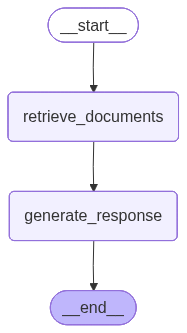

In [43]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    messages = state.get("messages", [])
    question = state["question"]
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(context=formatted_docs, conversation=messages, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)
graph_builder.add_edge(START, "retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

We're setting up a simple graph in LangGraph. If you want to learn more about LangGraph, I would highly recommend taking a look at our LangGraph Academy course.

You can also pass in metadata or other fields through an optional config

In [44]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"foo": "bar"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing with LangChain, you need to configure your environment by setting a few environment variables. After that, you can log a trace using the LangGraph integration. For detailed steps, refer to the Trace With LangChain guide.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 1398, 'total_tokens': 1446, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-CMqbhriQaf8yTJqp2miMdkU4tPQqW', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None

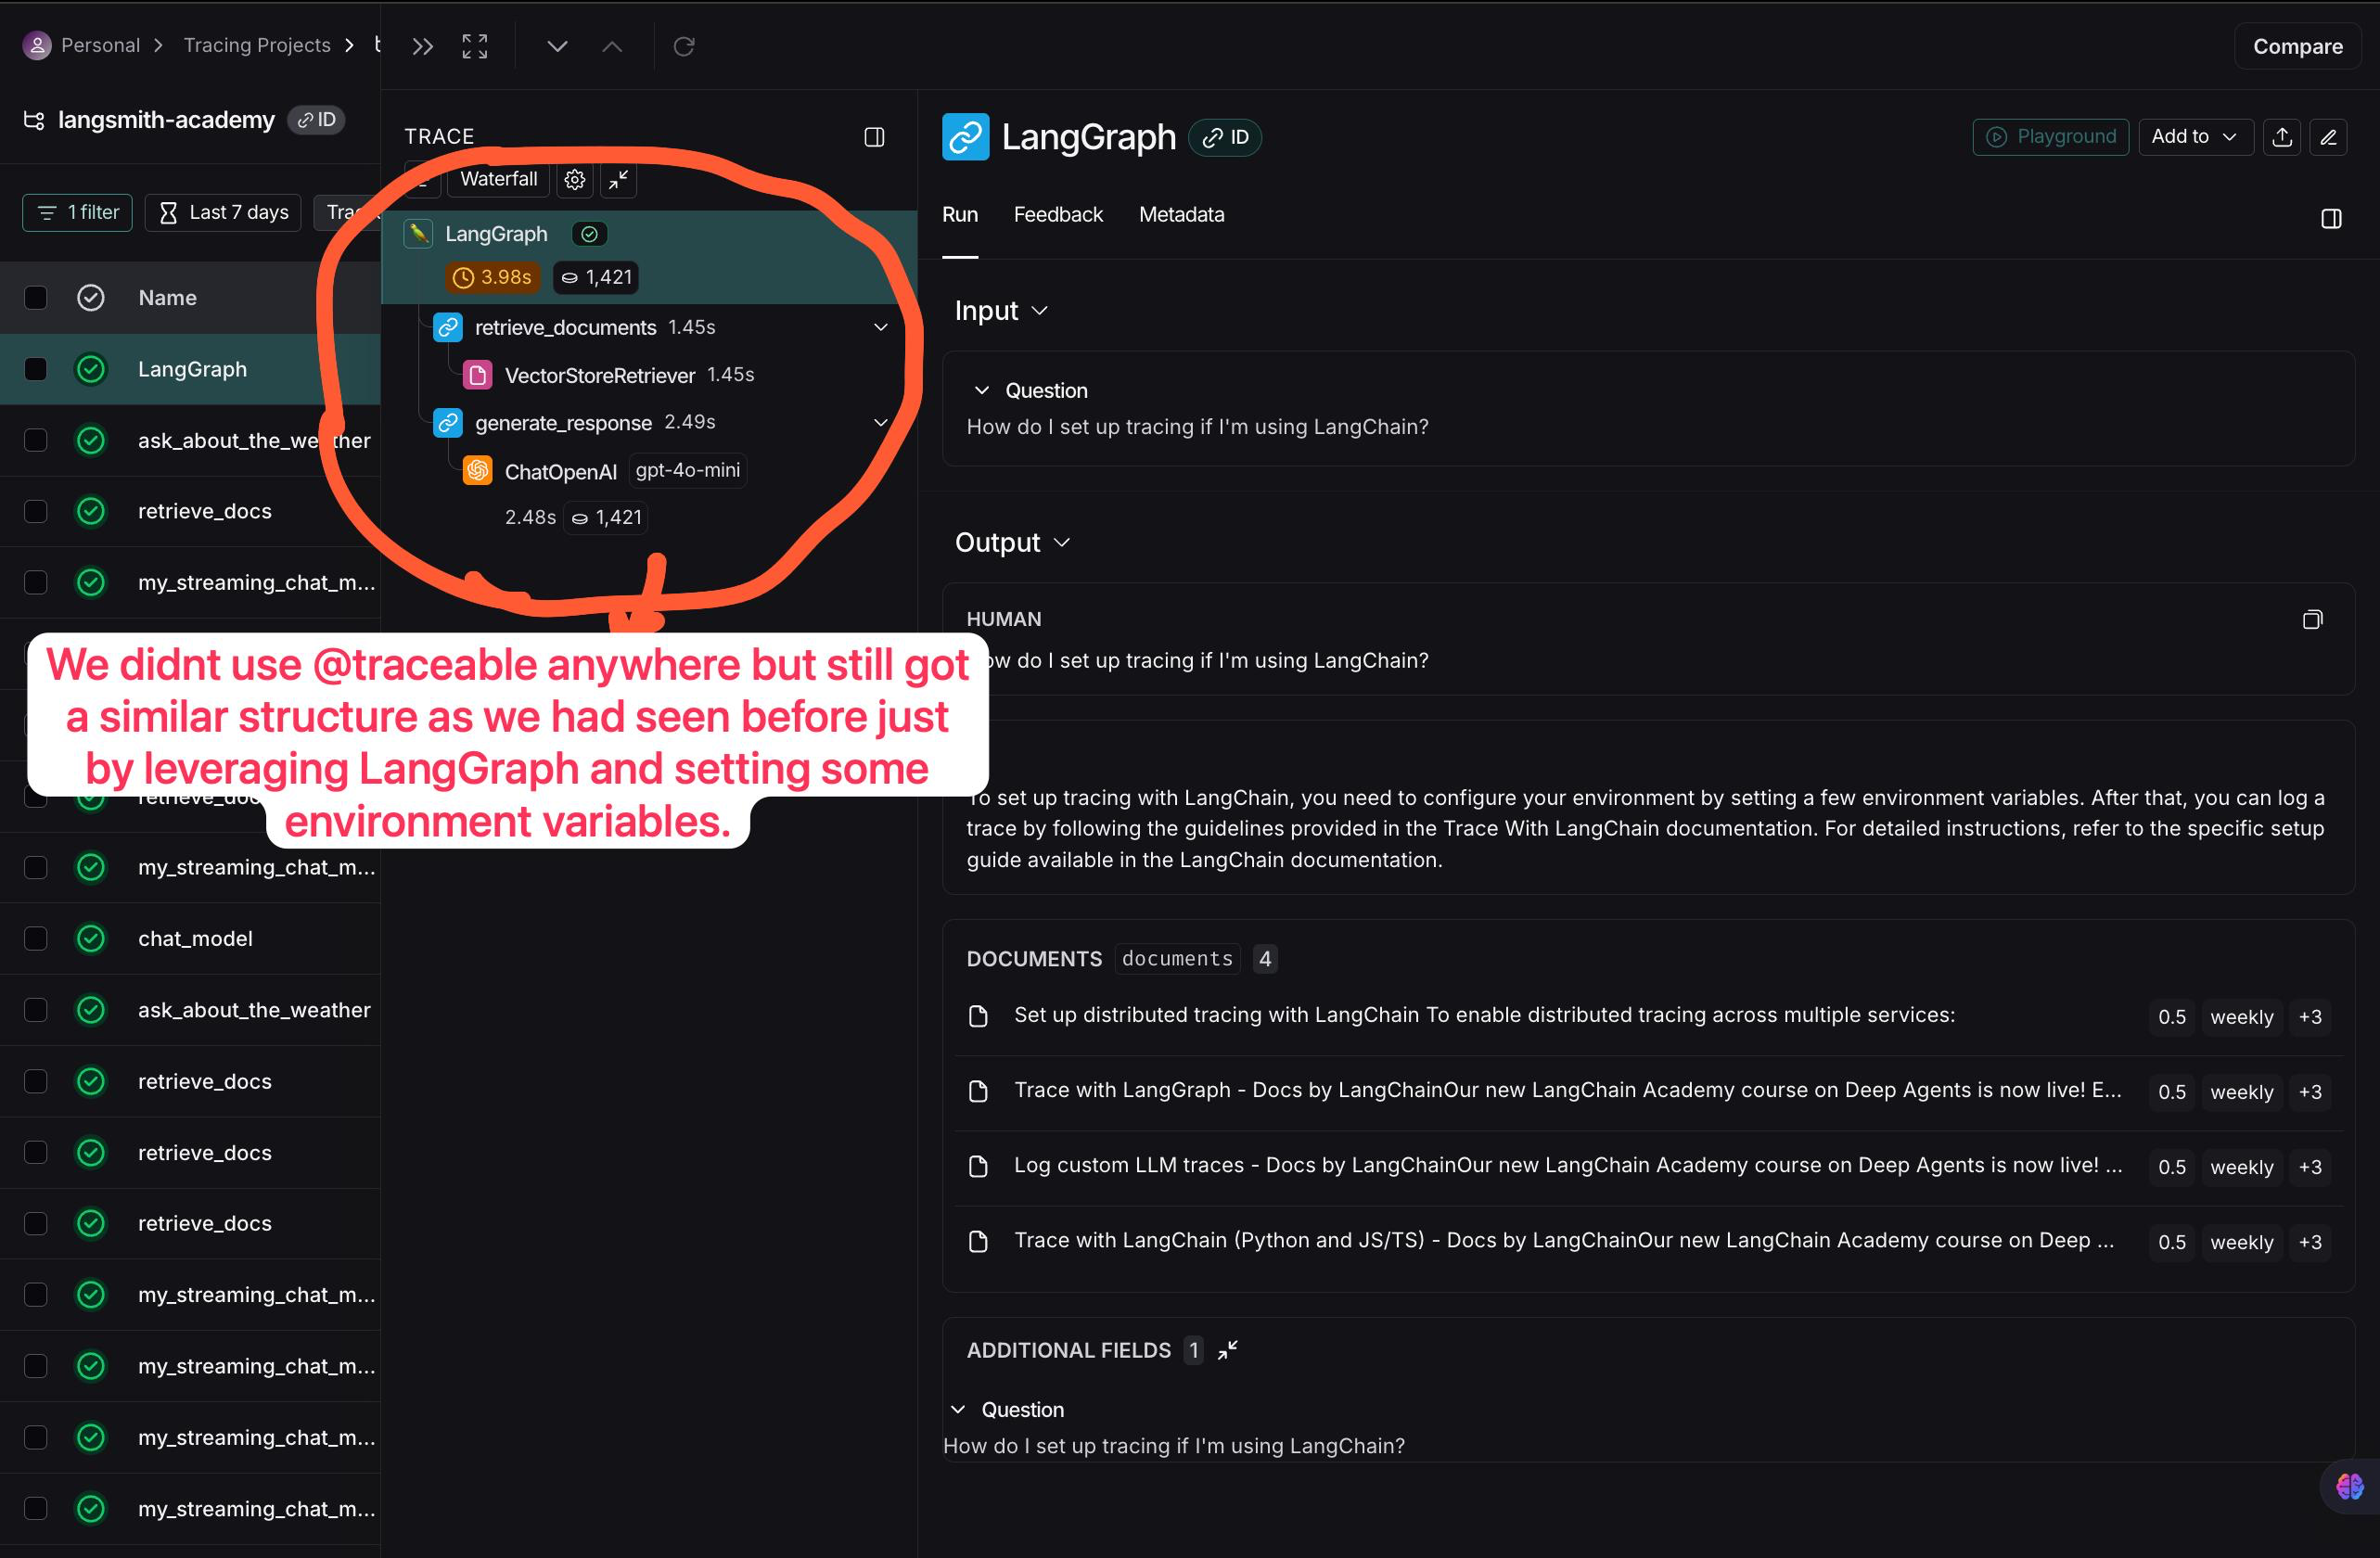

### My question with custom metadata:

In [45]:
question = "What is langGraph/LANGCHAIN tracing"
simple_rag_graph.invoke({"question": question}, config={"metadata": {"my_request1": "Doritos"}})

{'question': 'What is langGraph/LANGCHAIN tracing',
 'messages': [HumanMessage(content='What is langGraph/LANGCHAIN tracing', additional_kwargs={}, response_metadata={}),
  AIMessage(content='LangGraph and LangChain tracing involves monitoring and logging the workflows of applications that utilize LangChain modules or other SDKs. It allows developers to trace agentic workflows, enabling better observability and evaluation of large language model (LLM) interactions. This setup includes configuring environment variables, logging traces, and managing trace data effectively.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 1396, 'total_tokens': 1461, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6

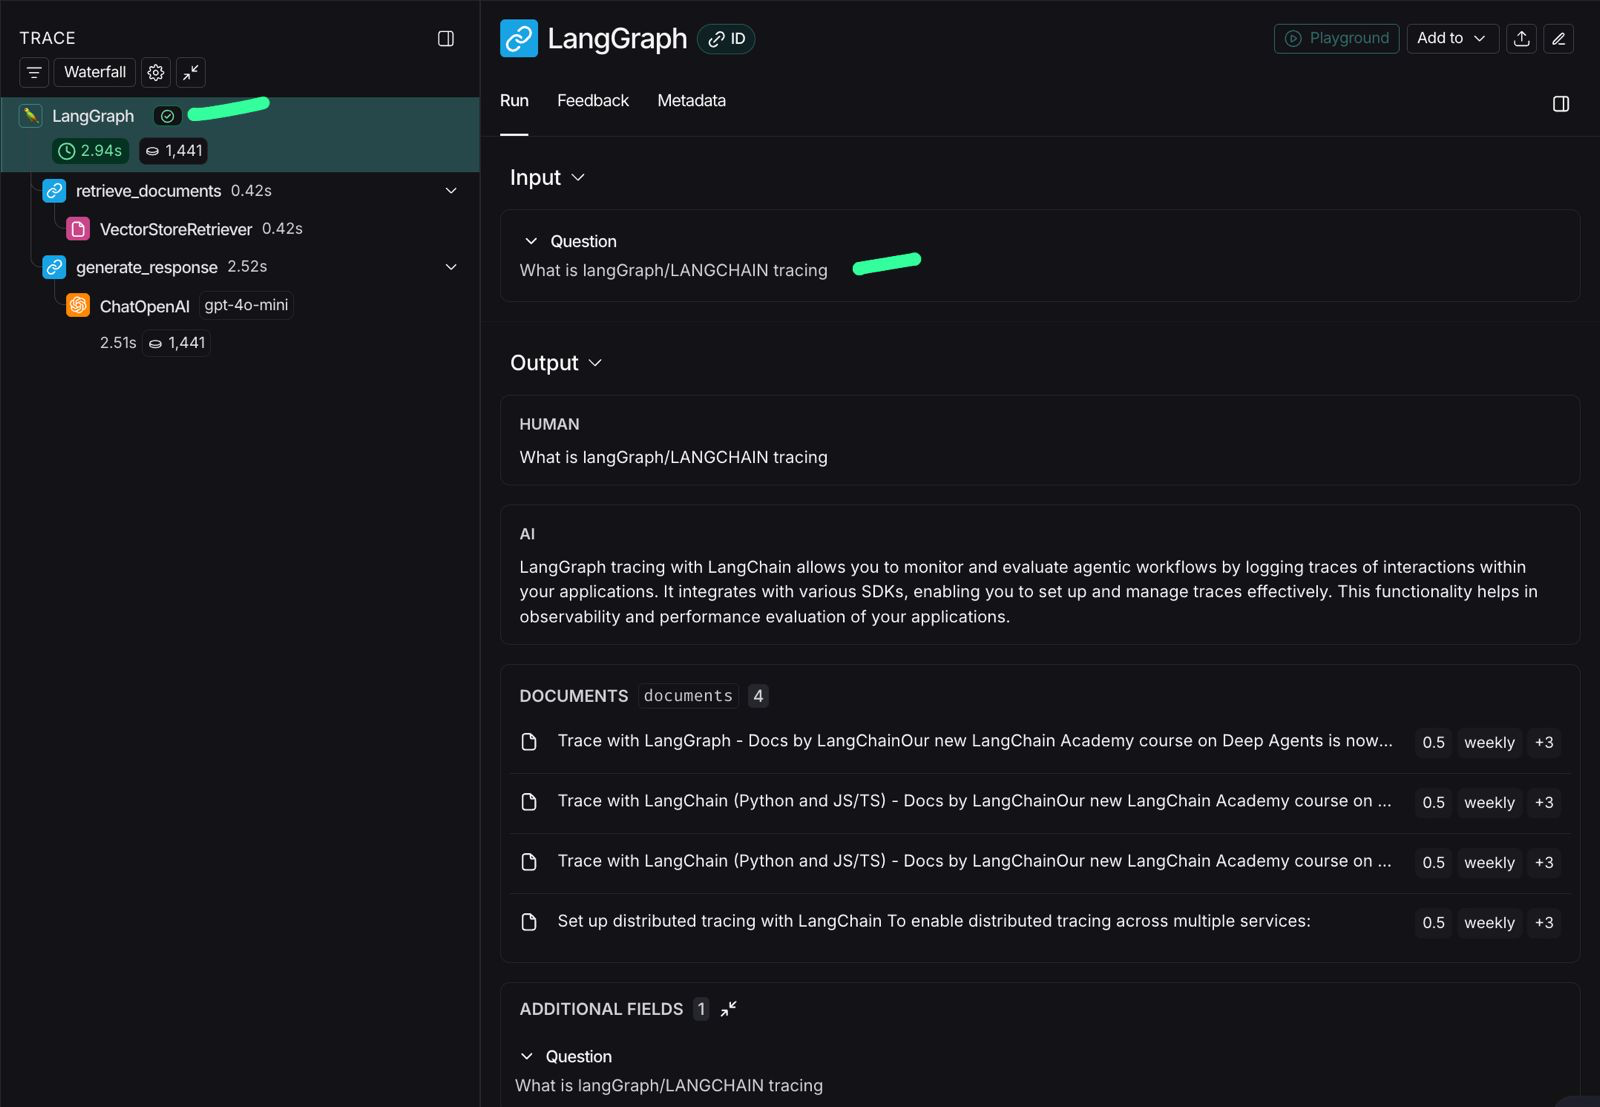

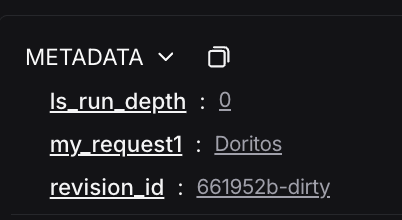

##### Let's take a look in LangSmith!

### Inference : It is a built-in tool for tracing all the Langchain and LangGraph tools we use, we just need to make some changes to our .env to make it work properly .

## Tracing Context Manager

In Python, you can use the trace context manager to log traces to LangSmith. This is useful in situations where:

You want to log traces for a specific block of code.
You want control over the inputs, outputs, and other attributes of the trace.
It is not feasible to use a decorator or wrapper.
Any or all of the above.
The context manager integrates seamlessly with the traceable decorator and wrap_openai wrapper, so you can use them together in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_2.png)

In [46]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
# TODO: Remove traceable, and use with trace()

def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # TODO: Use with trace()
    with trace(
         name="Generate Response",
          run_type="chain", 
          inputs={"question": question, "formatted_docs": formatted_docs},
          metadata={"foo": "bar"},
      ) as ls_trace:
      messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    response = call_openai(messages)
    # TODO: End your trace and write outputs to LangSmith
    ls_trace.end(outputs={"output": response})
    return response

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [47]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the tracing context in Python, you can use the `tracing_context` context manager provided by LangSmith. Wrap your code that you want to trace within the `with ls.tracing_context(enabled=True):` block, which will enable tracing for that specific invocation. If you want to disable tracing for certain parts, you can set `enabled=False` within another `tracing_context` block.


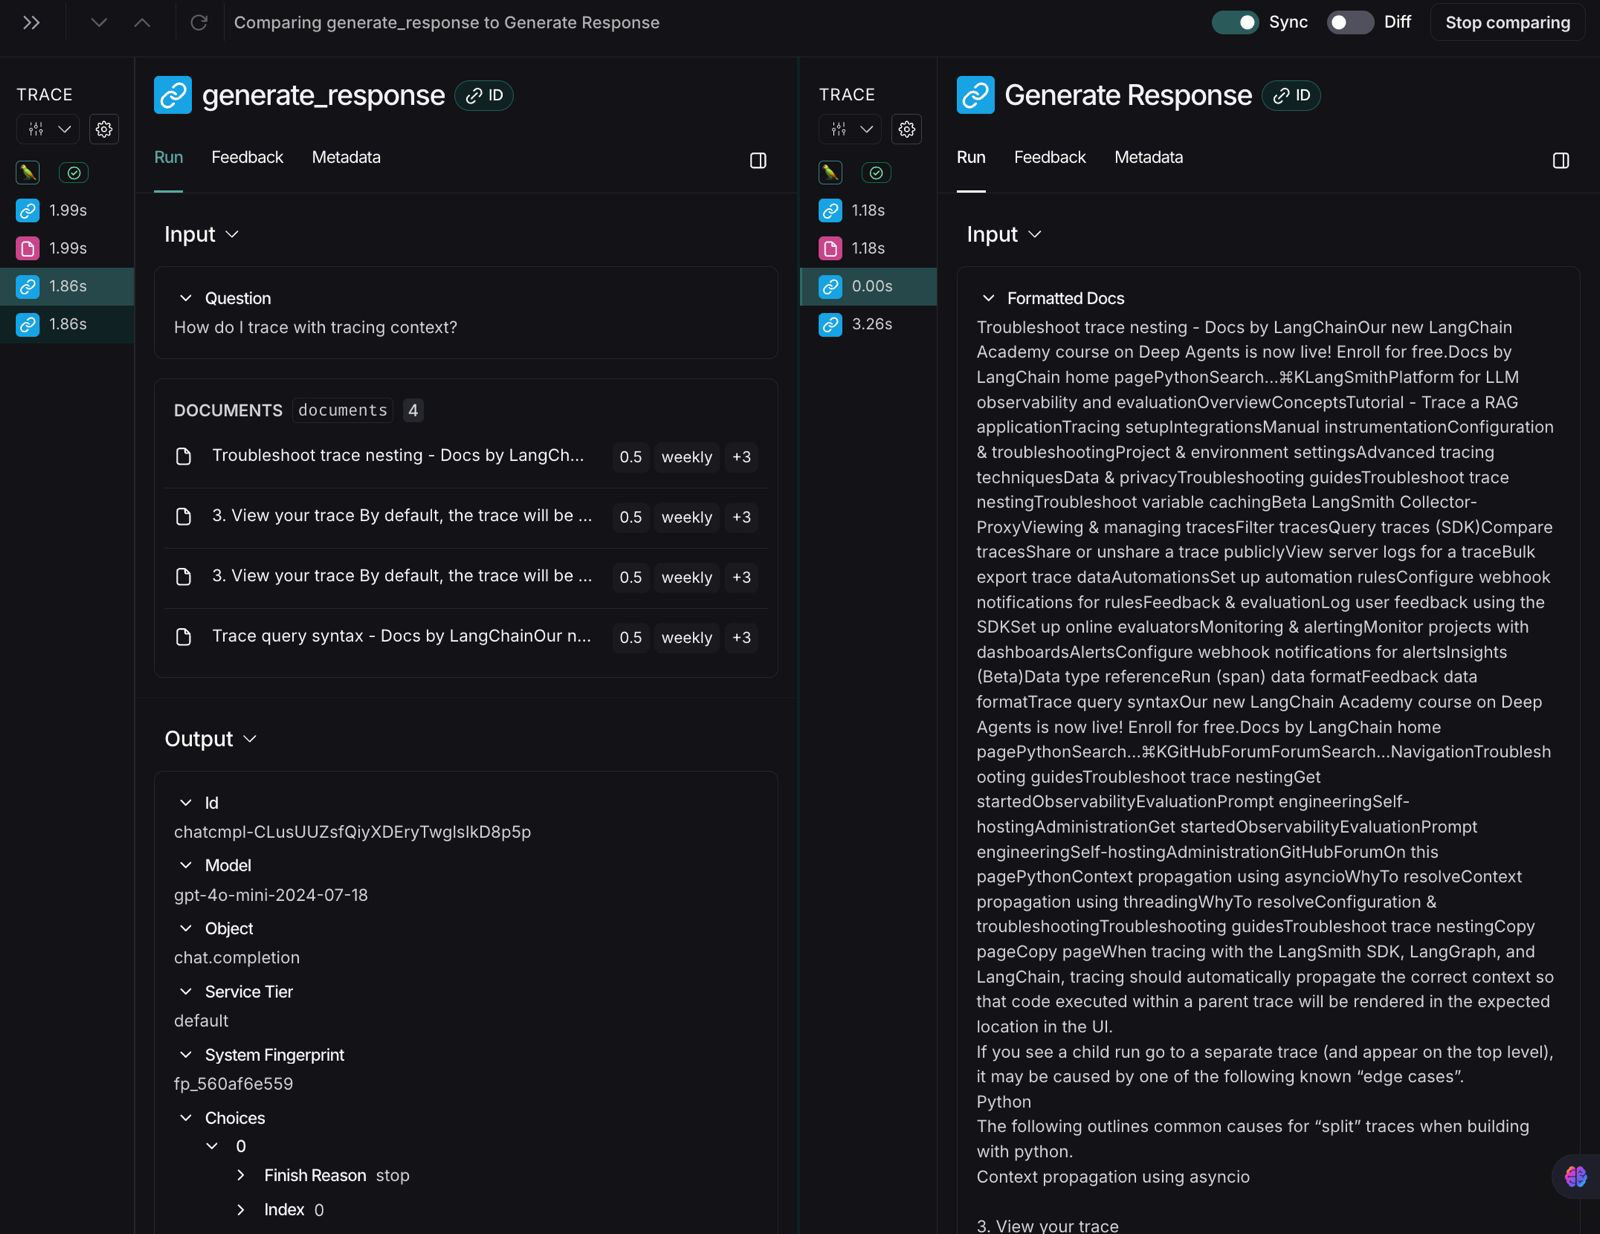


#### We can see the difference between traceable (left) and trace (right)

In [48]:
question = "What is tracing context"
ai_answer = langsmith_rag(question)
print(ai_answer)

Tracing context refers to the information that is propagated through different parts of an application during execution, allowing for the tracking of operations and their relationships. In the context of LangChain and LangSmith, it ensures that code executed within a parent trace is correctly associated with its child traces, facilitating observability and debugging. Proper context propagation is essential for accurately rendering traces in the user interface.


## My Inference : We use trace() when we want to trace a specific block of code for example in the upper code snippet we used trace() to trace just the formatted docstring instead of the whole block, It is useful if want to focus on a specific block of code 

## wrap_openai

The wrap_openai/wrapOpenAI methods in Python/TypeScript allow you to wrap your OpenAI client in order to automatically log traces -- no decorator or function wrapping required! The wrapper works seamlessly with the @traceable decorator or traceable function and you can use both in the same application.

You still need to set your `LANGSMITH_API_KEY` and `LANGSMITH_TRACING`

![AWTT](../../images/alternative_ways_to_trace_3.png)

In [49]:
# TODO: Import wrap_openai
from langsmith.wrappers import wrap_openai
import openai
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# TODO: Wrap the OpenAI Client
openai_client = wrap_openai(openai.Client())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # TODO: We don't need to use @traceable on a nested function call anymore,
    # wrap_openai takes care of this for us
    

    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

@traceable(run_type="chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


In [50]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

To trace with `wrap_openai`, you need to wrap your OpenAI client using the `wrap_openai` method from LangSmith, ensuring that the `LANGSMITH_TRACING` environment variable is set to 'true'. Additionally, make sure to set the `LANGSMITH_API_KEY` environment variable for your API key, and optionally, the `LANGSMITH_WORKSPACE_ID` for specifying the workspace. This setup will allow you to automatically log traces without needing decorators or function wrapping.


The wrapped OpenAI client accepts all the same langsmith_extra parameters as @traceable decorated functions

In [51]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

openai_client.chat.completions.create(
    model=MODEL_NAME,
    messages=messages,
    langsmith_extra={"metadata": {"foo": "bar"}},
)

ChatCompletion(id='chatcmpl-CMqdwXsKT7FTgrJhAh1mnIbaQtnka', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The color of the sky varies depending on various factors, such as the time of day, weather conditions, and atmospheric particles. During a clear day, the sky often appears blue due to the scattering of sunlight by the atmosphere. However, at sunrise and sunset, the sky can display shades of orange, pink, and red. Overcast conditions may cause the sky to look gray. At night, the sky is typically dark and can be illuminated by stars and the moon.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1759561612, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_560af6e559', usage=CompletionUsage(completion_tokens=94, prompt_tokens=13, total_tokens=107, completion_tokens_details=CompletionTokensDetails(accepted_prediction_

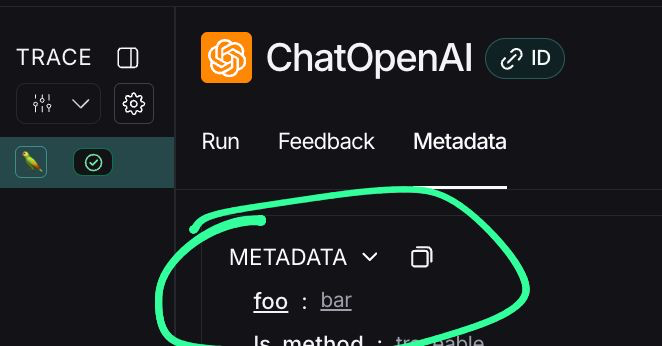

#### my code, along with custom runtime metadta

In [52]:
question = "What is wrap_openai?"
ai_answer = langsmith_rag_with_wrap_openai(question, langsmith_extra={"metadata": {"my_wrap_openai_metadata": "yess!!", "my_request":"3"}})
print(ai_answer)

The `wrap_openai` method is a function in Python/TypeScript that allows you to wrap your OpenAI client to automatically log traces without needing to use decorators or manually wrap functions. This wrapper ensures messages, including tool calls and multimodal content, are nicely rendered in LangSmith. It is used in conjunction with environment variables like `LANGSMITH_TRACING` and `LANGSMITH_API_KEY` for proper tracing configuration.


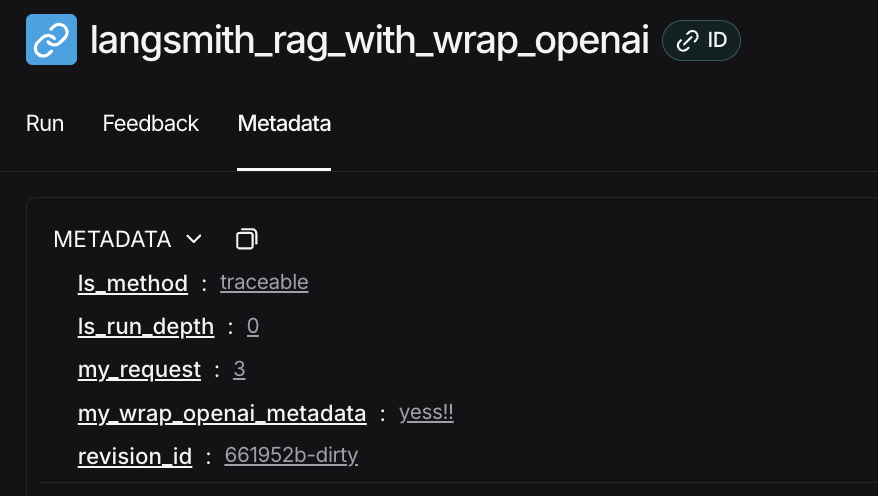

# DEFINED A RAG FUNCTION OF MY OWN AND RAN ALL THE TRACING METHODS ON IT

In [53]:


import os
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import SKLearnVectorStore
from openai import OpenAI
from langsmith import traceable, trace
from langsmith.wrappers import wrap_openai



# --- 2. LOAD AND PREPARE THE DATA ---
print("Loading and processing the document...")
loader = WebBaseLoader("https://en.wikipedia.org/wiki/Role-playing_game")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = SKLearnVectorStore.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings(),
)
print("Document processed and vector store created.")



# METHOD 1: Use wrap_openai() on the client for automatic tracing of LLM calls
client = wrap_openai(OpenAI())

# METHOD 2: Use @traceable for a self-contained component (retrieval)
@traceable
def retrieve_the_docs(question: str):
    """
    Retrieves relevant documents from the vector store.
    This function is traced as a single, automatic step.
    """
    #print("--> Retrieving documents...")
    return vectorstore.similarity_search(question)

# METHOD 3: Use with trace() for a manual, granular trace of a process
def generate_the_response(question: str, documents: list):
    
    formatted_docs = "\n\n".join([doc.page_content for doc in documents])

    # Manually start a trace for this specific block of logic
    with trace(
        name="Generate the Response",
        run_type="chain", # Treat this run like a chain
        inputs={"question": question, "context": formatted_docs}
    ) as ls_trace:
        if not documents:
            return "I don't know, the information is not available in the source."

        prompt = f"""
        You are a helpful assistant. Answer the user's question based only on the following context:

        Context:
        {formatted_docs}

        Question: {question}

        If the answer is not in the context, say "I don't know, the information is not available in the source."
        """

        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt},
            ]
        )
        final_answer = response.choices[0].message.content

        ls_trace.end(outputs={"answer": final_answer})
        return final_answer



@traceable
def rag_bot(question: str):
    """
    The main RAG orchestrator that calls the other components.
    This function creates the top-level trace.
    """
    print(f"\nReceived question: {question}")
    documents = retrieve_the_docs(question)
    response = generate_the_response(question, documents)
    return response




Loading and processing the document...
Document processed and vector store created.


In [54]:

answer1 = rag_bot("What are the origins of role-playing games?")
print(f"Answer 1: {answer1}")




Received question: What are the origins of role-playing games?
Answer 1: The origins of role-playing games can be traced back to the first commercially available RPG, Dungeons & Dragons (D&D), which was published in 1974. The game was inspired by fantasy literature and the wargaming hobby.


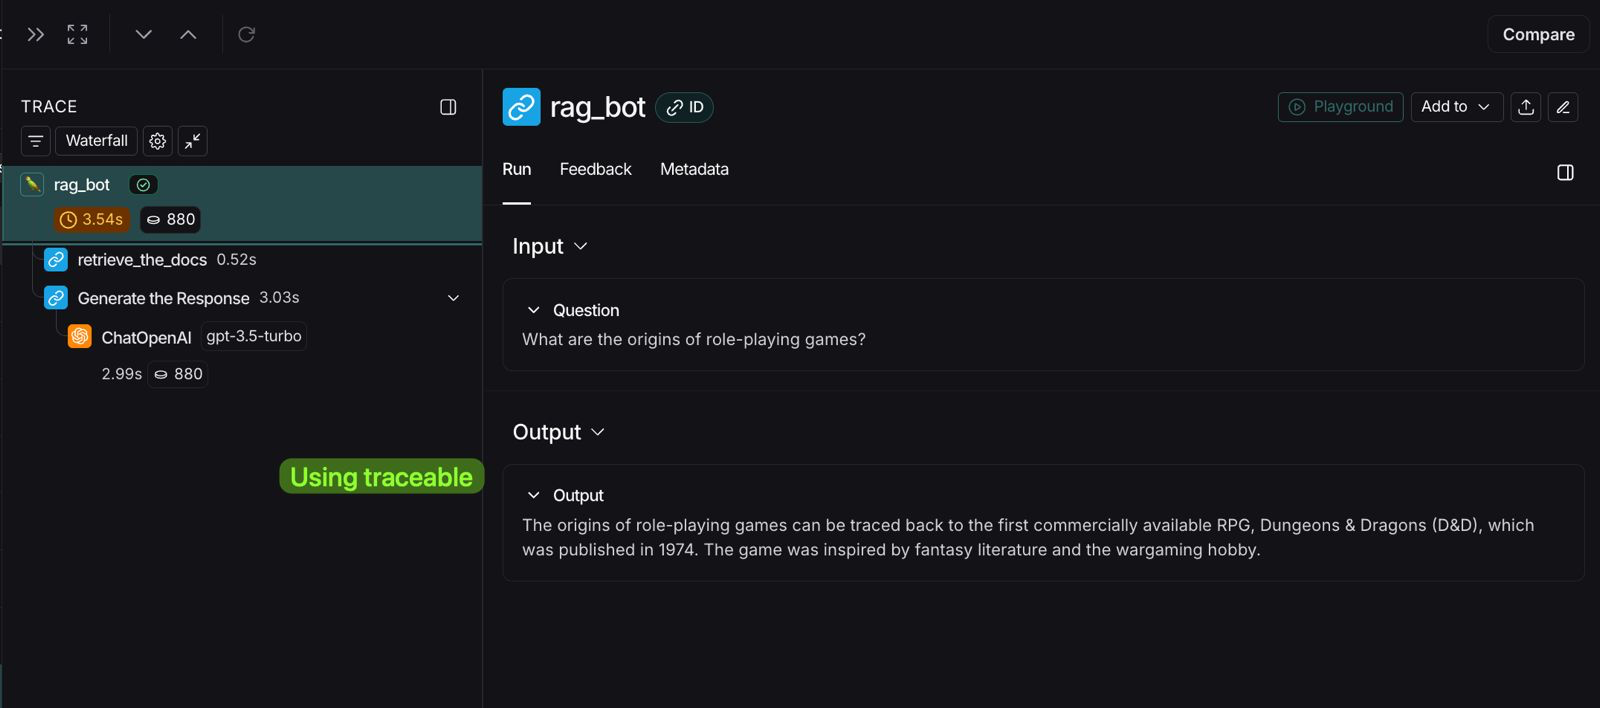

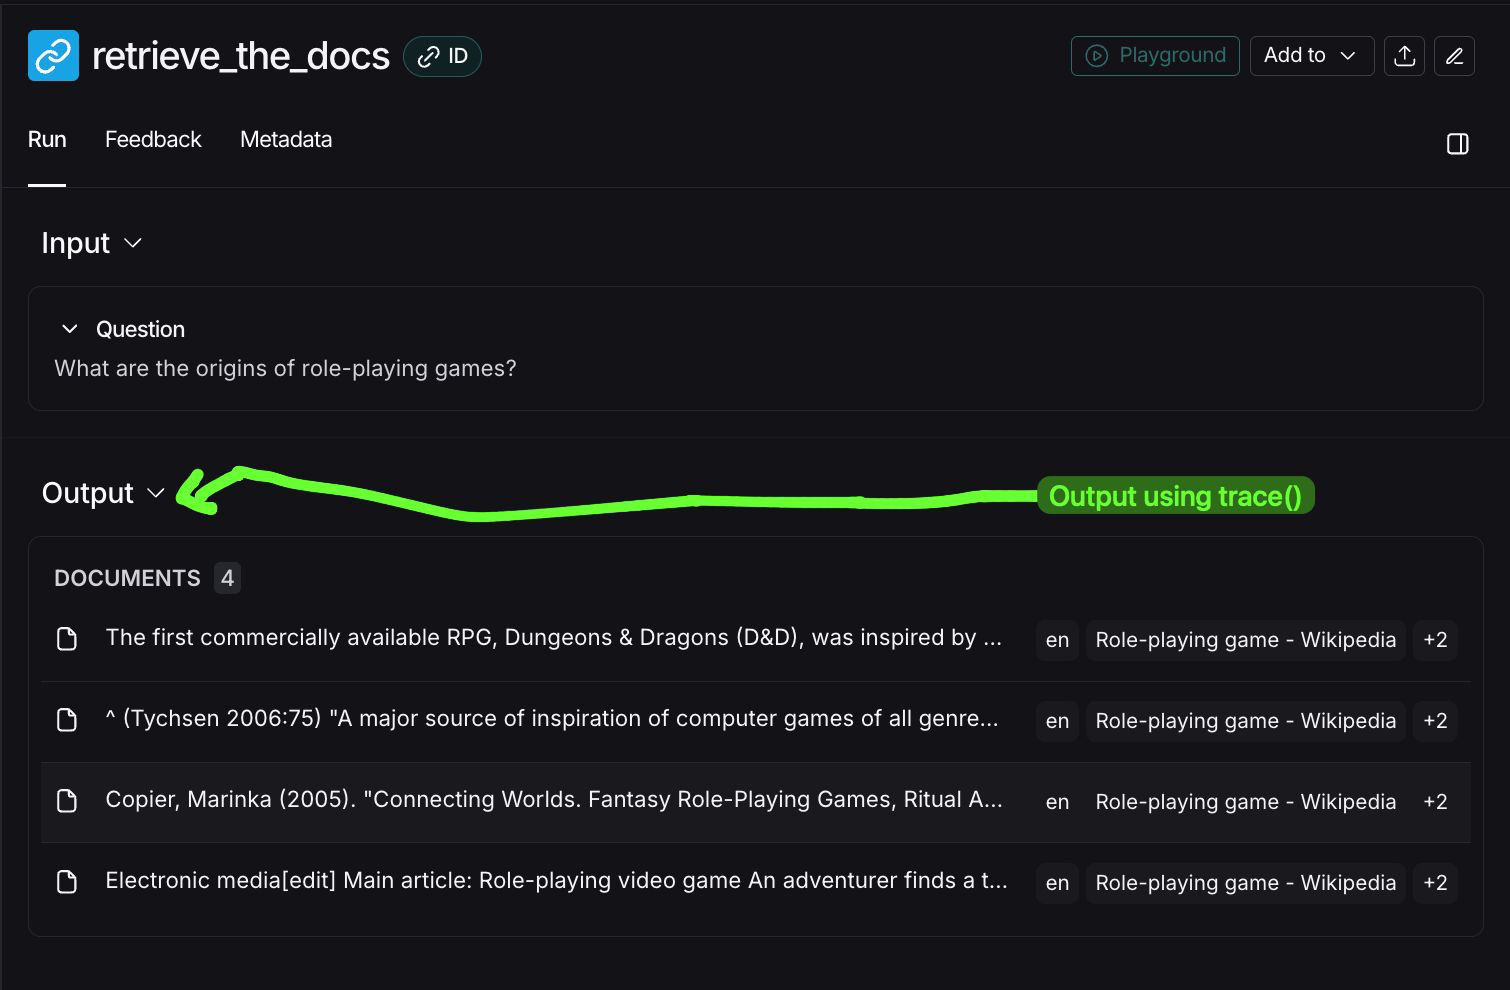

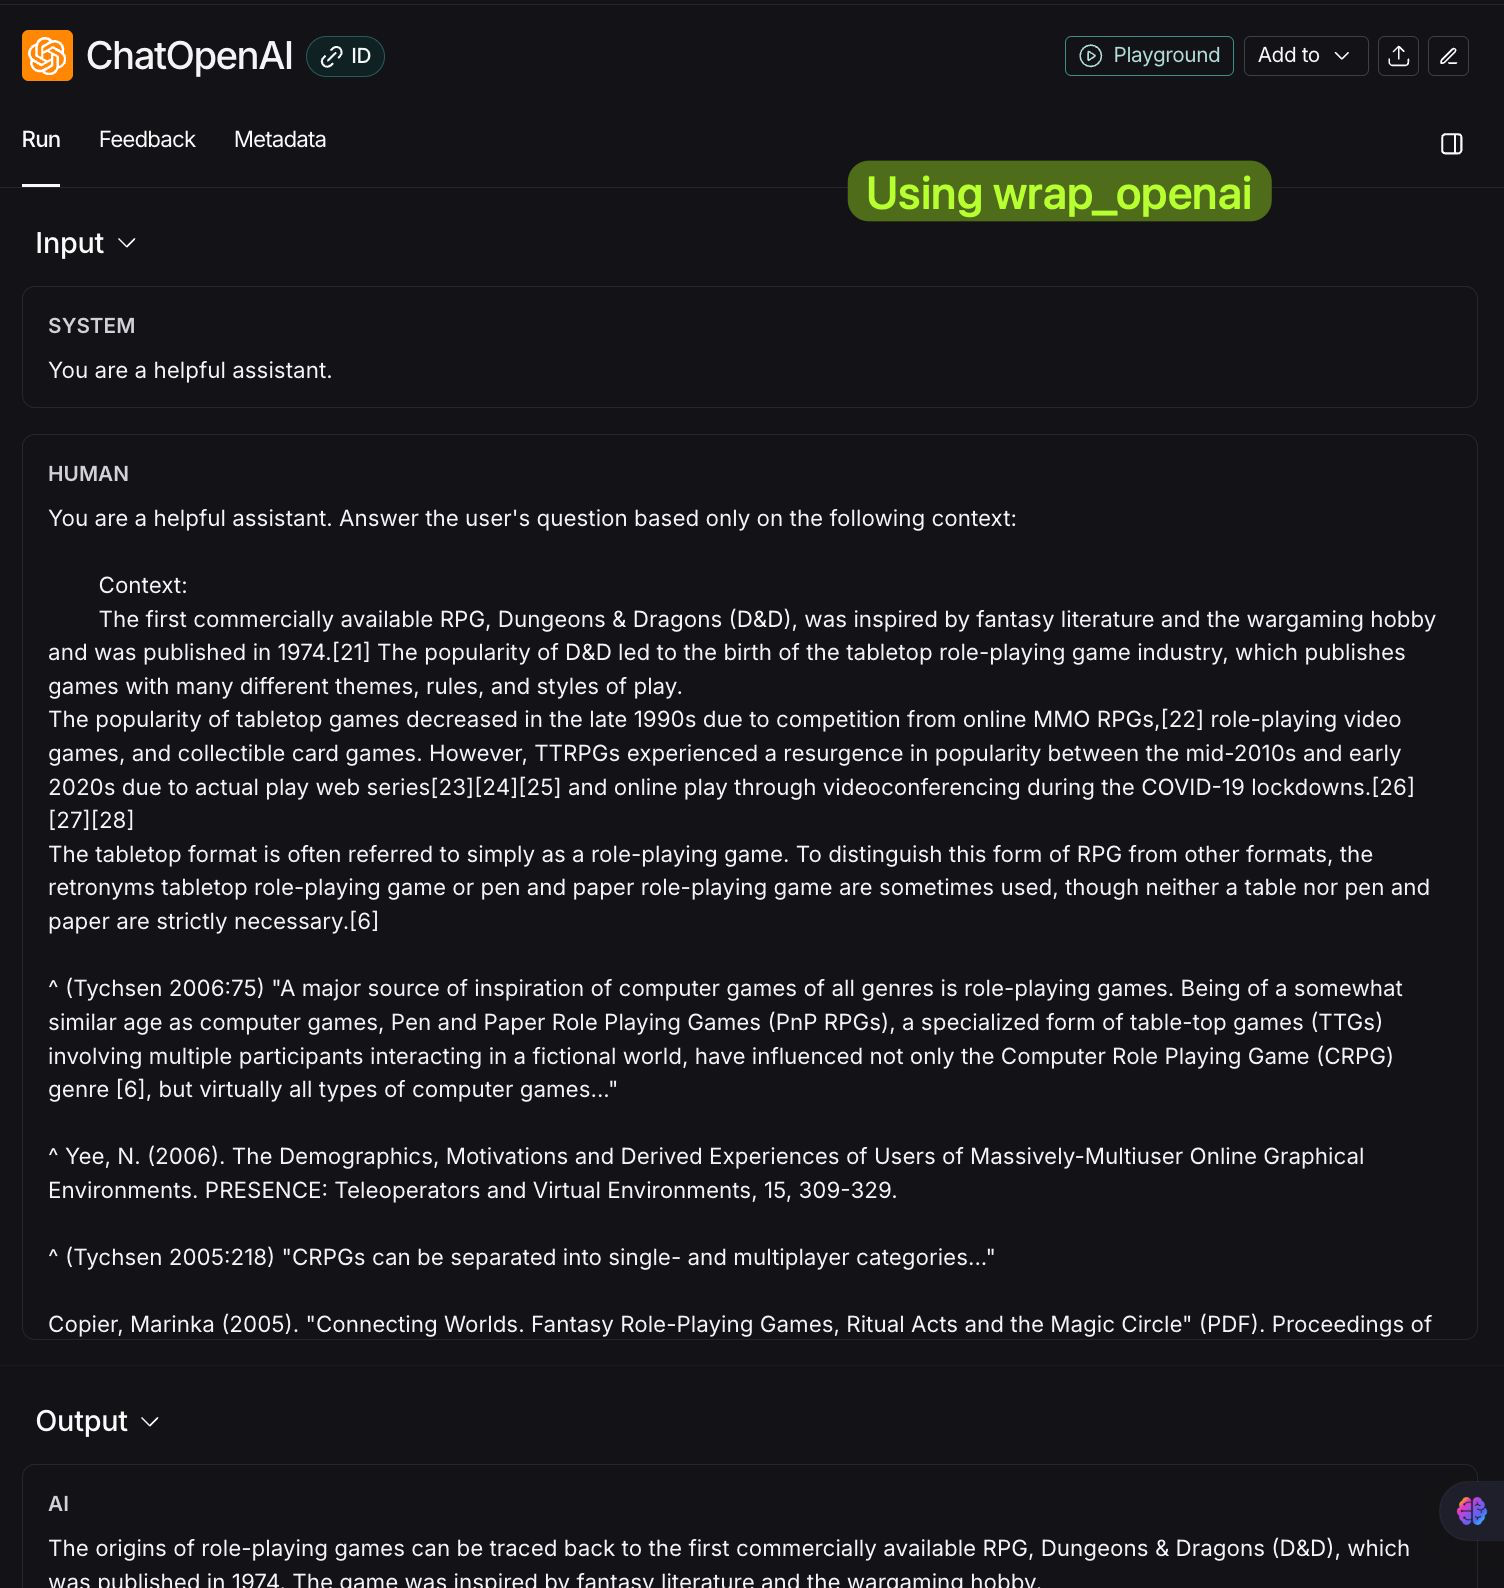

In [55]:
answer2 = rag_bot("What is a gamemaster?")
print(f"Answer 2: {answer2}")




Received question: What is a gamemaster?
Answer 2: A gamemaster (GM) is a participant in role-playing games (RPGs) who has special duties such as presenting the fictional setting, arbitrating the results of character actions, and maintaining the narrative flow within the game. In tabletop and live-action RPGs, the GM performs these duties in person, while in video RPGs, some functions of a GM are fulfilled by the game engine. Additionally, in some multi-player video RPGs, participants can take on a GM role through a visual interface called a GM toolkit, although their abilities may be limited by the available technology.


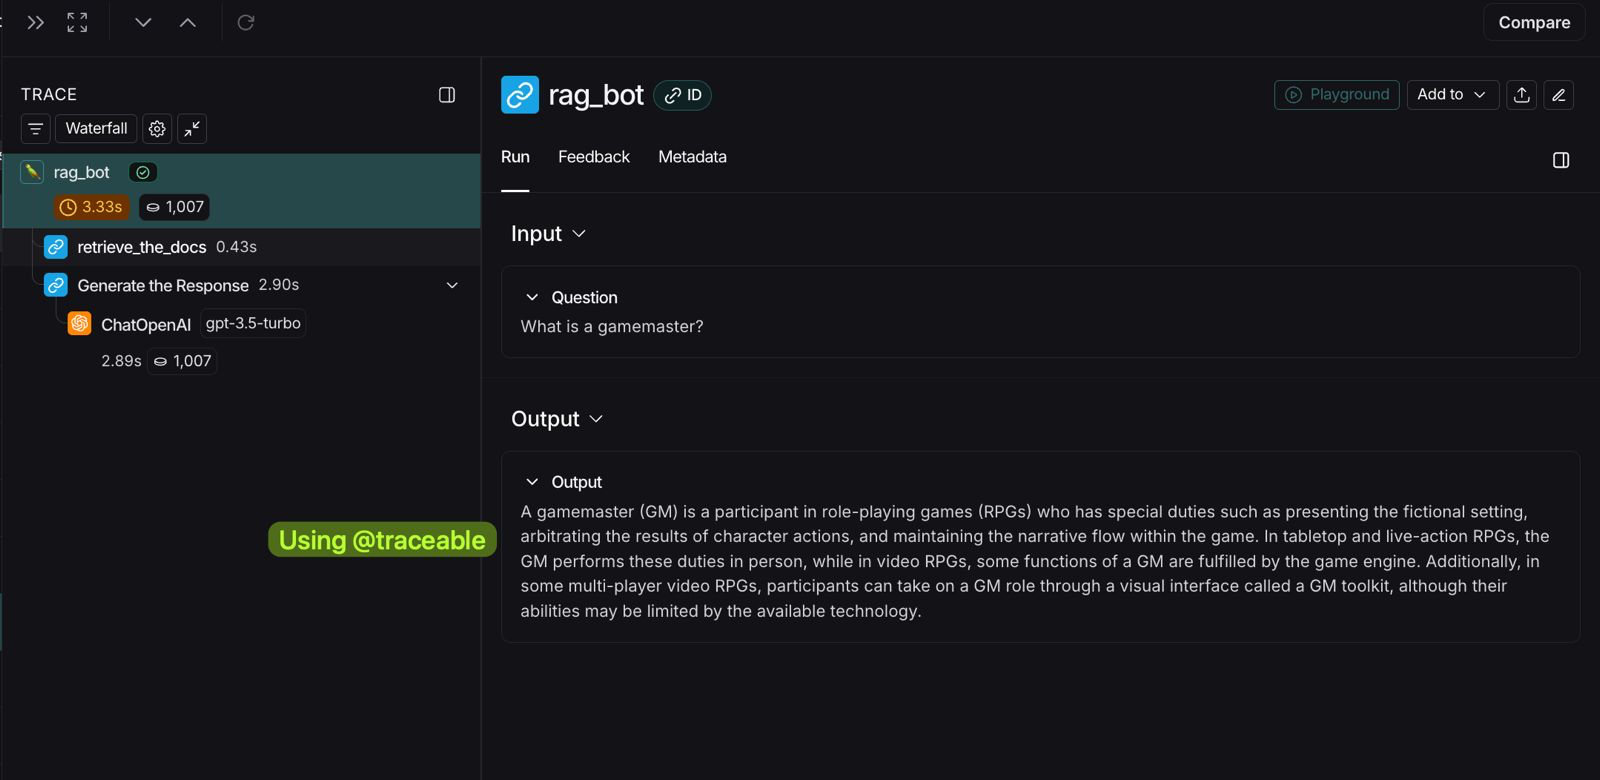


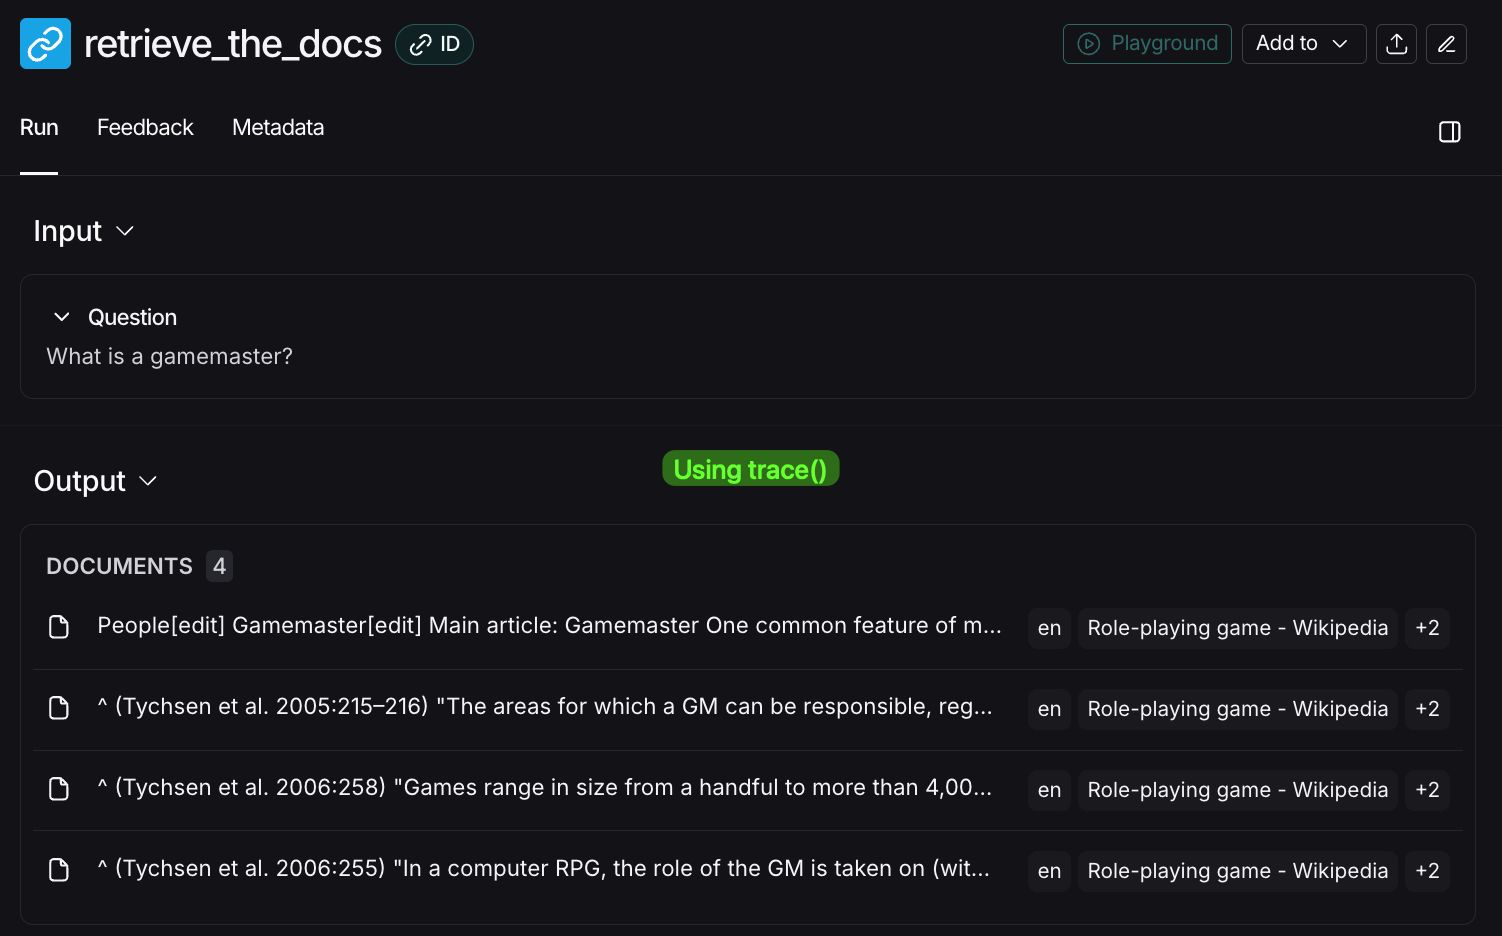


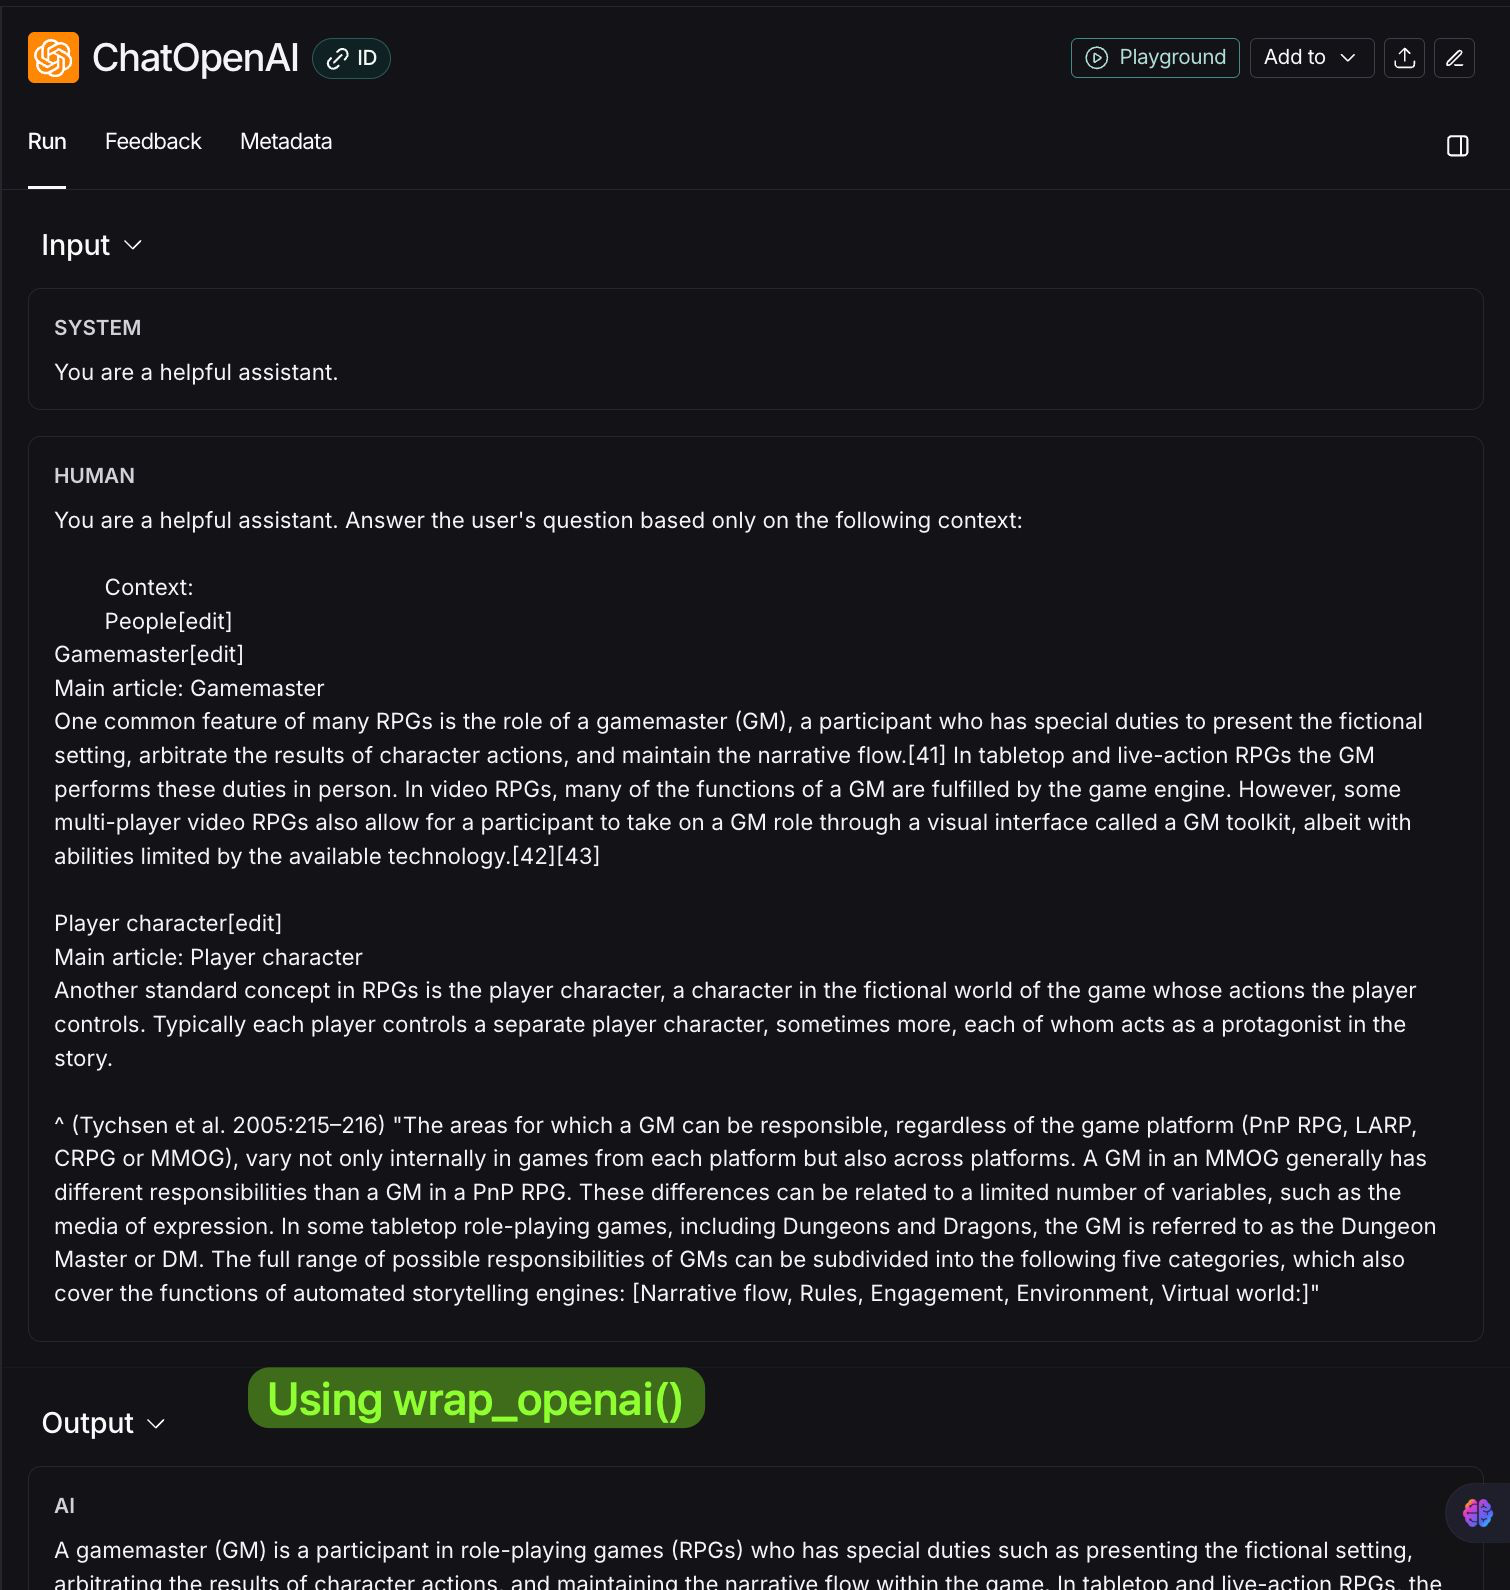

Example 3 and 4 are similar to 1 and 2, In example 4 I gave it a question which wasm't in the source to ensure that it replies with (i dont know)

In [56]:
answer3 = rag_bot("What exactly is an RPG give some examples?")
print(f"Answer 3: {answer3}")


Received question: What exactly is an RPG give some examples?
Answer 3: A role-playing game (RPG) is a game where players assume and play out the roles of characters in a fictional setting, taking responsibility for acting out these roles within a narrative. Examples of RPGs include tabletop role-playing games (TRPGs), live action role-playing (LARP), single-player role-playing video games, multiplayer text-based Multi-User Dungeons (MUDs), and massively multiplayer online role-playing games (MMORPGs).


In [57]:
answer4 = rag_bot("how to cook rice?")
print(f"Answer 4: {answer4}")


Received question: how to cook rice?
Answer 4: I don't know, the information is not available in the source.


## Second example with a different source website and with the LangGraph tracing as well

In [58]:



import os
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import SKLearnVectorStore
from openai import OpenAI
from langsmith import traceable, trace
from langsmith.wrappers import wrap_openai
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document
from langgraph.graph import StateGraph, END, START





loader = WebBaseLoader("https://en.wikipedia.org/wiki/DC_Comics")
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = SKLearnVectorStore.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings(),
)
print("Document processed and vector store created.")

# ==============================================================================
# --- METHODS 1, 2, and 3: Manual and Component-level Tracing ---
# (These are the same as before to provide a comparison)
# ==============================================================================
# METHOD 1: wrap_openai()
client = wrap_openai(OpenAI())
# METHOD 2: @traceable
@traceable
def retrieve_documents_manual(question: str):
    #print("--> Retrieving documents (Manual)...")
    return vectorstore.similarity_search(question)
# METHOD 3: with trace()
def generate_response_manual(question: str, documents: list):
    # ... [Same function as before] ...
    #print("--> Generating response (Manual)...")
    formatted_docs = "\n\n".join([doc.page_content for doc in documents])
    with trace(name="Generate Response", run_type="chain", inputs={"question": question, "context": formatted_docs}) as ls_trace:
        if not documents: return "I don't know..."
        prompt = f"Context: {formatted_docs}\n\nQuestion: {question}\n\nAnswer:"
        response = client.chat.completions.create(model="gpt-4o-mini", messages=[{"role": "user", "content": prompt}])
        final_answer = response.choices[0].message.content
        ls_trace.end(outputs={"answer": final_answer})
        return final_answer

@traceable
def rag_bot_manual(question: str):

    documents = retrieve_documents_manual(question)
    response = generate_response_manual(question, documents)
    return response

# ==============================================================================
# --- METHOD 4: LangGraph for 'Out-of-the-Box' Graph Tracing ---
# ==============================================================================


class RagGraphState(TypedDict):
    question: str
    documents: List[Document]
    answer: str

# Define the nodes of the graph
def retrieve_node(state: RagGraphState):
    """Node that retrieves documents from the vector store."""
    #print("---NODE: Retrieving documents---")
    question = state["question"]
    documents = vectorstore.similarity_search(question)
    return {"documents": documents}

def generate_node(state: RagGraphState):
    """Node that generates an answer based on the retrieved documents."""
    #print("---NODE: Generating answer---")
    question = state["question"]
    documents = state["documents"]

    if not documents:
        return {"answer": "I don't know, the information is not available in the source."}

    context = "\n\n".join([doc.page_content for doc in documents])
    prompt = f"""You are a helpful assistant. Answer the user's question based only on the following context:
    Context: {context}
    Question: {question}
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    response = llm.invoke(prompt)
    return {"answer": response.content}

# Build the graph
workflow = StateGraph(RagGraphState)

# Add the nodes
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("generate", generate_node)

# Define the edges
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile the graph into a runnable object
langgraph_rag_app = workflow.compile()

def rag_bot_langgraph(question: str):
    """Invokes the fully-traced LangGraph app."""
   
    # The input to a graph is a dictionary matching the state
    inputs = {"question": question}
    # The output is the final state of the graph
    final_state = langgraph_rag_app.invoke(inputs)
    return final_state["answer"]






Document processed and vector store created.


In [59]:

answer1 = rag_bot_manual("What are the origins of dc comics?")
print(f"Answer: {answer1}")


Answer: DC Comics originated in the early 1930s, initially as a publisher named National Allied Publications, founded by Malcolm Wheeler-Nicholson. The company later adopted the names National Comics and National Periodical Publications before officially branding itself as DC Comics in 1977. The name "DC" comes from the popular comic series "Detective Comics," which featured Batman.

The company gained prominence in the late 1930s with the introduction of iconic characters such as Superman, created by Jerry Siegel and Joe Shuster in 1938, followed by Batman, created by Bob Kane and Bill Finger in 1939. These characters helped establish the superhero genre and laid the foundation for the modern comic book industry.

As superhero popularity waned in the late 1940s, DC Comics diversified its offerings, including genres like science fiction, Westerns, humor, and romance, while continuing to publish a few key superhero titles like Action Comics and Detective Comics. Over the years, DC Comic

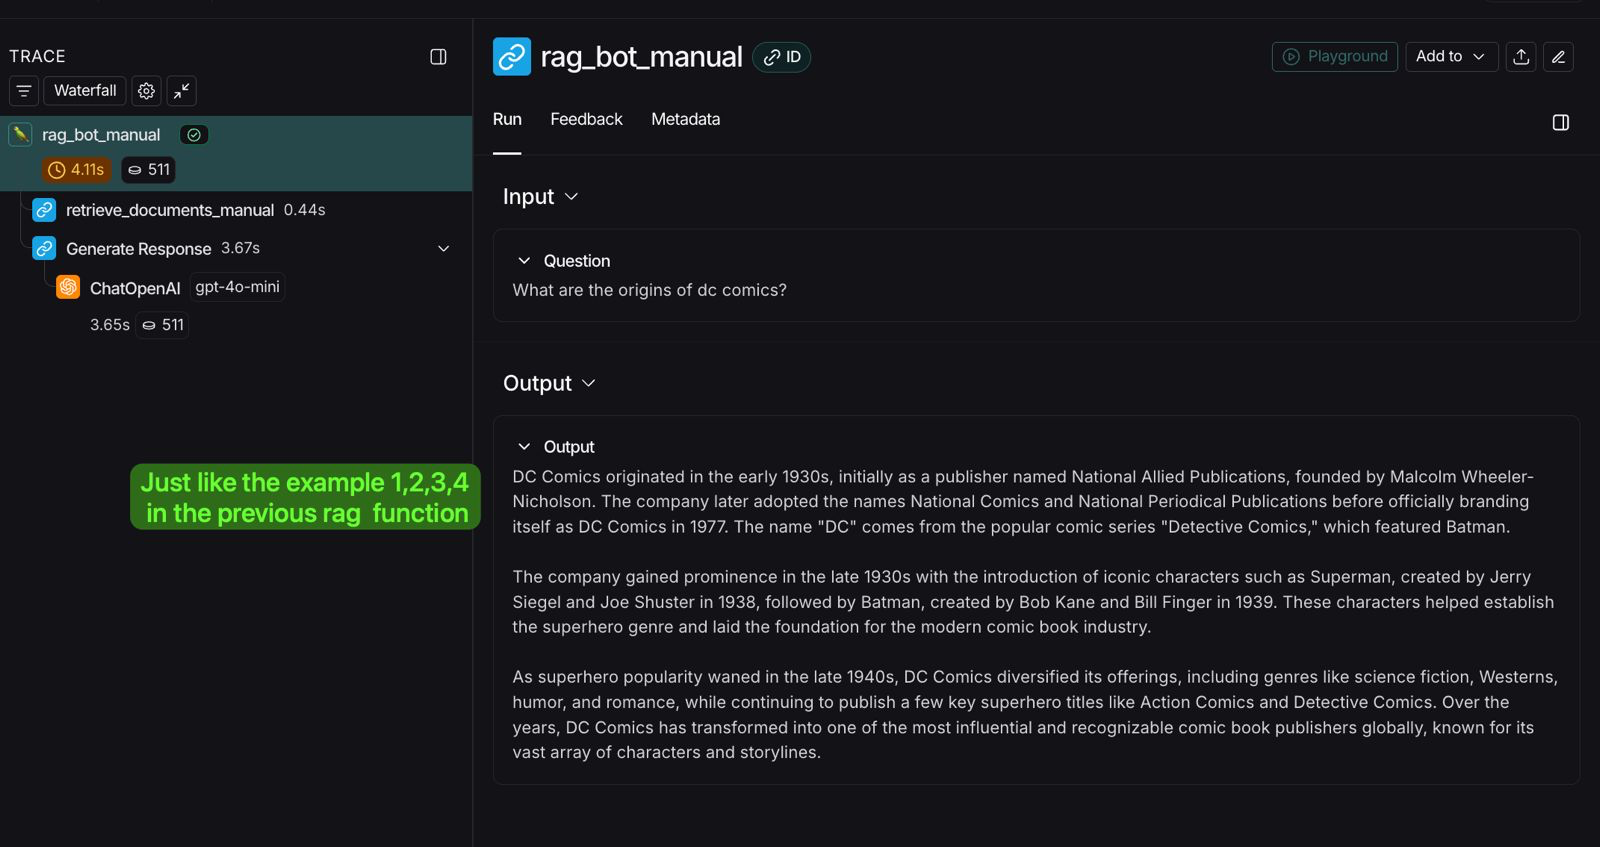

In [60]:

answer2 = rag_bot_langgraph("Who is superman?")
print(f"Answer: {answer2}")

Answer: Superman is a famous superhero introduced in Action Comics #1 in June 1938. He is known for his origin story that reveals he comes from an unnamed planet, later known as Krypton. Superman is characterized as one of the most enduring superheroes and has a significant supporting character in Lois Lane, who is depicted as his first romantic interest.


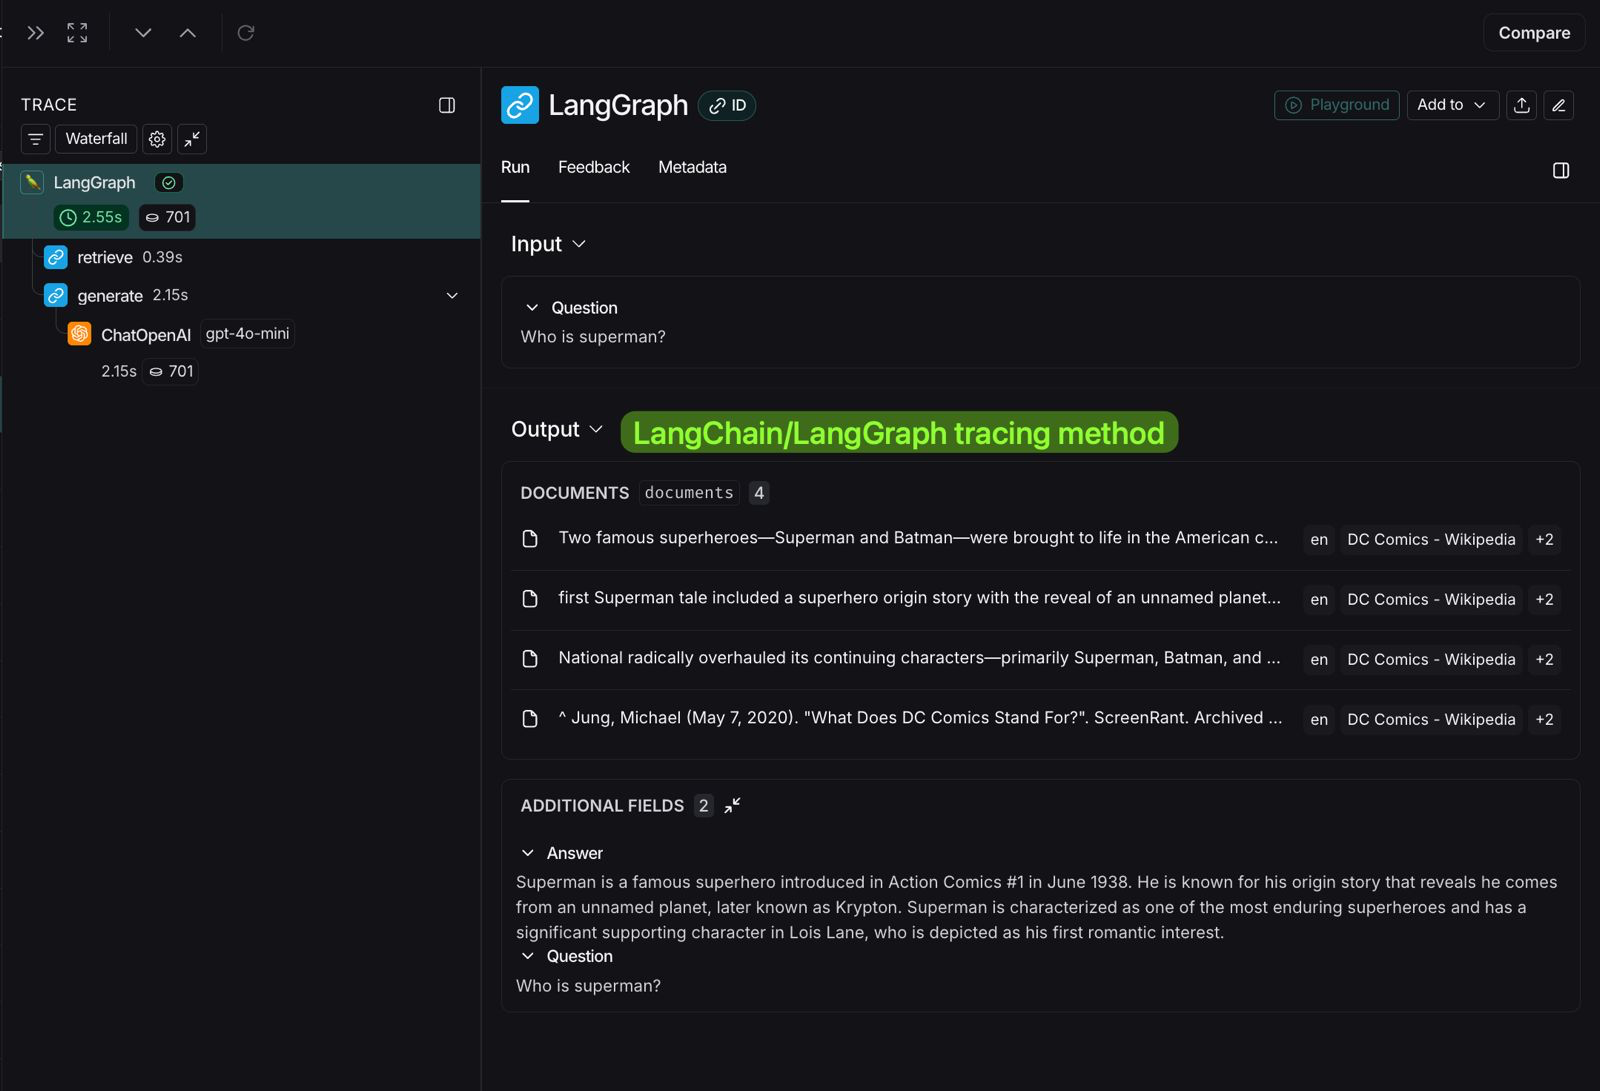

## RunTree has NOT been covered in the lecture videos for this module

#### I have tried to run it once and try to understand whats happening

## [Advanced] RunTree

Another, more explicit way to log traces to LangSmith is via the RunTree API. This API allows you more control over your tracing - you can manually create runs and children runs to assemble your trace. You still need to set your `LANGSMITH_API_KEY`, but `LANGSMITH_TRACING` is not necessary for this method.

![AWTT](../../images/alternative_ways_to_trace_4.png)

In [61]:
from dotenv import load_dotenv
# I have my env variables defined in a .env file
load_dotenv(dotenv_path="../../.env", override=True)

True

Let's go ahead and set `LANGSMITH_TRACING` to false, as we are using RunTree to manually create runs in this case.

In [62]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

True

We have rewritten our RAG application, except this time we pass a RunTree argument through our function calls, and create child runs at each layer. This gives our RunTree the same hierarchy that we were automatically able to establish with @traceable

In [63]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name="Retrieve Documents",
        run_type="retriever",
        inputs={"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs={"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name="Generate Response",
        run_type="chain",
        inputs={"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    openai_response = call_openai(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def call_openai(
    parent_run: RunTree, messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name="OpenAI Call",
        run_type="llm",
        inputs={"messages": messages},
    )
    openai_response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name="Chat Pipeline",
        run_type="chain",
        inputs={"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output
    


In [64]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with RunTree, you can use the `RunTree.fromHeaders` method to create a run tree from the request headers. Then, utilize the `withRunTree` helper to ensure the run tree is propagated within traceable invocations. This allows you to maintain the context of the trace throughout your application's operations.


RunTree is used when we need to manually construct a detailed, multi-step trace. we create a root RunTree for the overall process and then use .create_child() to instrument each specific sub-component, giving the clear, hierarchical view you see in your trace.